# TF SubDetector
### Training a Gun classifier to use after an object detector

This notebook walks you through the fune-tuning of a classifier for gun detection.

The training data should be set up in the following way. All instances of each class should reside in a separate
directory. For each class, the name of the directory should be then name of the class. These named directories 
should be the only data inside the specified training directory. For example, in the case of gun detection, use
the following directory structure:


--train_data

    --yesguns 
        --img00.jpg
        --img01.jpg
        -- (...)  
    ---noguns
        --img98.jpg
        --img99.jpg
        -- (...)
--val_data

    --yesguns 
        --img00.jpg
        --img01.jpg
        -- (...)  
    ---noguns
        --img98.jpg
        --img99.jpg
        -- (...)


Here the data has been split into two classes, and then further split into a training set and a validation set.
Therefore, the 'labeling' of the data is actually nothing more than a process of sorting it into the correct directory. 

## Introduction

We will use a pre-trained model on a new dataset using so-called Transfer Learning, by re-routing the output of the original model just prior to its classification layers and instead use a new classifier that we create. Because the original model was 'frozen' its weights will not be further optimized, so whatever was learned by all the previous layers in the model, will not be changed by the new data-set.

This notebook also shows how to do Fine-Tuning using the Keras API for Tensorflow. We will use the gun dataset compiled by KickView. We will explore using several pre-trained models for fine-tuning.

## Flowchart

The idea is to re-use a pre-trained model (e.g., VGG16 model), which consists of several convolutional layers (actually blocks of multiple convolutional layers), followed by some fully-connected / dense layers and then a softmax output layer for the classification. 

The dense layers are responsible for combining features from the convolutional layers for final classification. So when the VGG16 model is used on another dataset we can replace all the dense layers for something more prefered.

The difference between Transfer Learning and Fine-Tuning is that in Transfer Learning we only optimize the weights of the new classification layers we have added, while we keep the weights of the original VGG16 model. In Fine-Tuning we optimize both the weights of the new classification layers we have added, as well as some or all of the layers from the VGG16 model.

![Flowchart of Transfer Learning & Fine-Tuning](images/10_transfer_learning_flowchart.png)

## Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import PIL
import tensorflow as tf
import numpy as np
import os

These are the imports from the Keras API.

In [2]:
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.python.keras.applications import VGG16
from tensorflow.python.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.optimizers import Adam, RMSprop, SGD

from tensorflow.python.keras.preprocessing.image import image
from tensorflow.python.keras import applications
from tensorflow.python.keras.applications.inception_v3 import InceptionV3
from tensorflow.python.keras.applications.mobilenet import MobileNet
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.callbacks import ModelCheckpoint

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

This was developed using Python 3.6 and TensorFlow version:

In [3]:
tf.__version__

'1.14.0'

In [4]:
tf.enable_eager_execution()

## Dataset: Guns

The directories where the images are now stored.

In [4]:
# train_dir = '/data/gun_chips/train/'
# test_dir = '/data/gun_chips/val/'

train_dir = '/data/mwir_gun_chips/train/'
test_dir = '/data/mwir_gun_chips/val/'

# Directory with our training images
train_guns_dir = os.path.join(train_dir, 'gun')
print ('Total training gun images:', len(os.listdir(train_guns_dir)))

# Directory with our training dog pictures
train_noguns_dir = os.path.join(train_dir, 'nogun')
print ('Total training nogun images:', len(os.listdir(train_noguns_dir)))

# Directory with our validation cat pictures
validation_guns_dir = os.path.join(test_dir, 'gun')
print ('Total validation gun images:', len(os.listdir(validation_guns_dir)))

# Directory with our validation dog pictures
validation_noguns_dir = os.path.join(test_dir, 'nogun')
print ('Total validation nogun images:', len(os.listdir(validation_noguns_dir)))

Total training gun images: 460
Total training nogun images: 992
Total validation gun images: 51
Total validation nogun images: 110


In [5]:
train_guns_dir

'/data/mwir_gun_chips/train/gun'

In [6]:
image_size = 256 # All images will be resized to 160x160
batch_size = 32

# Rescale all images by 1./255 and apply image augmentation to training images
train_datagen = ImageDataGenerator(            
                rescale=1./255)
                #rotation_range=15,
                #width_shift_range=0.05,
                #height_shift_range=0.05,
                #shear_range=0.05,
                #zoom_range=[0.9, 1.1],
                #horizontal_flip=False,
                #vertical_flip=False,
                #fill_mode='nearest')
validation_datagen = ImageDataGenerator(rescale=1./255)

Keras uses a so-called data-generator for inputting data into the neural network, which will loop over the data for eternity.
If we have a small training-set it can help to artificially inflate its size by making various transformations to the images. We can use a built-in data-generator that can make these random transformations. This is also called an augmented dataset.

In [ ]:
# train_datagen = ImageDataGenerator(
#      rescale=1./255,
#      rotation_range=180,
#      width_shift_range=0.1,
#      height_shift_range=0.1,
#      shear_range=0.1,
#      zoom_range=[0.9, 1.5],
#      horizontal_flip=True,
#      vertical_flip=True,
#      fill_mode='nearest')

In [9]:
# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
                train_dir,  # Source directory for the training images
                target_size=(image_size, image_size),
                batch_size=batch_size,
                # Since we use binary_crossentropy loss, we need binary labels
                class_mode='binary')

Found 1452 images belonging to 2 classes.


In [8]:
# Flow validation images in batches using test_datagen generator
validation_generator = validation_datagen.flow_from_directory(
                test_dir, # Source directory for the validation images
                target_size=(image_size, image_size),
                batch_size=batch_size,
                class_mode='binary')

Found 161 images belonging to 2 classes.


## Class Weights

The dataset could be imbalanced because it has fewer images in one class than another. This can cause a problem during training because the neural network will be shown many more examples of one class than another.

Here we use scikit-learn to calculate weights that will properly balance the dataset. These weights are applied to the gradient for each image in the batch during training, so as to scale their influence on the overall gradient for the batch.

In [9]:
from sklearn.utils.class_weight import compute_class_weight

In [10]:
cls_train = train_generator.classes 

In [11]:
class_weight = compute_class_weight(class_weight='balanced',
                                    classes=np.unique(cls_train),
                                    y=cls_train)

Note the weights for each class. The gradient should be amplified for the class with fewer images, while the gradient should be lowered for the class with more images.

In [12]:
class_weight

array([1.57826087, 0.73185484])

## Pre-Trained Model:

The following creates an instance of the pre-trained model using the Keras API. This may automatically downloads the required files if you don't have them already.

In [13]:
IMG_SHAPE = (image_size, image_size, 3)

### Create the base model from the pre-trained model MobileNet V2
#base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
#                                               include_top=False,
#                                               weights='imagenet')


base_model = VGG16(input_shape = IMG_SHAPE, include_top=False, weights='imagenet')

# Settings for inception:
#img_width, img_height = 640, 360
#base_model = InceptionV3(weights = 'imagenet', include_top=False, input_shape = (img_width, img_height, 3))
#base_model = InceptionV3(weights = 'imagenet', include_top=False, input_shape = (image_size, image_size, 3))


### Transfer Learning
The lower layers of a Convolutional Neural Network can recognize many different shapes or features in an image. It is the last few fully-connected layers that combine these featuers into classification of a whole image. So we can try and re-route the output of the last convolutional layer of the model to a new fully-connected neural network that we create for doing classification on the gun dataset.
First we print a summary of the model so we can see the names and types of its layers, as well as the shapes of the tensors flowing between the layers.

In [14]:
base_model.trainable = False   # Make the base model layers not trainable - "freeze" them

In [15]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [16]:
#transfer_layer = model.get_layer('block5_pool')   # VGG only
#transfer_layer = model.output    # inception only
#transfer_layer

We can create a new model to add to the base model for the fully connected layers.

In [17]:
model = Sequential([
  base_model,
  GlobalAveragePooling2D(input_shape=(8,8,512)),
  #Flatten(),
  #Dense(1024, activation='relu'),
  #Dropout(0.5),
  #Dense(512, activation='relu'),
  #Dropout(0.5),  
  Dense(1, activation='sigmoid')
])

Let's compile the new model and define the loss function and performance metrics.

In [18]:
#model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001),
#              loss='binary_crossentropy',
#              metrics=['accuracy'])

In [19]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 513       
Total params: 14,715,201
Trainable params: 513
Non-trainable params: 14,714,688
_________________________________________________________________


We can print out how many trainable layers there are in our new model. Only the new layers we defined should be traibale at this point.

In [21]:
len(model.trainable_variables)

2

An epoch normally means one full processing of the training-set. But the Keras data-generator we created above will produce batches of training-data for eternity. So we need to define the number of steps we want to run for each "epoch" so that when we multiply this by the batch-size we get the total length of data in each true epoch. These are parameters you can experiment with.

In [22]:
epochs = 15
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size

history = model.fit_generator(train_generator,
                              steps_per_epoch = steps_per_epoch,
                              epochs=epochs,
                              class_weight=class_weight,
                              workers=4,
                              validation_data=validation_generator,
                              validation_steps=validation_steps,
                              use_multiprocessing = True)

Epoch 1/15


W0831 19:39:21.547821 140633295456000 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


45/45 [==============================] - 10s 214ms/step - loss: 0.7618 - acc: 0.3092 - val_loss: 0.7254 - val_acc: 0.3125
Epoch 2/15
45/45 [==============================] - 5s 113ms/step - loss: 0.7037 - acc: 0.4387 - val_loss: 0.6805 - val_acc: 0.6938
Epoch 3/15
45/45 [==============================] - 5s 106ms/step - loss: 0.6712 - acc: 0.6754 - val_loss: 0.6551 - val_acc: 0.6812
Epoch 4/15
45/45 [==============================] - 5s 108ms/step - loss: 0.6555 - acc: 0.6824 - val_loss: 0.6420 - val_acc: 0.6812
Epoch 5/15
45/45 [==============================] - 5s 107ms/step - loss: 0.6476 - acc: 0.6796 - val_loss: 0.6347 - val_acc: 0.6812
Epoch 6/15
45/45 [==============================] - 5s 110ms/step - loss: 0.6399 - acc: 0.6826 - val_loss: 0.6306 - val_acc: 0.6812
Epoch 7/15
45/45 [==============================] - 5s 111ms/step - loss: 0.6296 - acc: 0.6886 - val_loss: 0.6269 - val_acc: 0.6812
Epoch 8/15
45/45 [==============================] - 5s 108ms/step - loss: 0.6314 - acc

Keras records the performance metrics at the end of each "epoch" so they can be plotted later. This hopefully shows that the loss generally decreased during training. Similarly, the classification accuracy generally improved on the training-set while it can be a bit more erratic on the test-set.

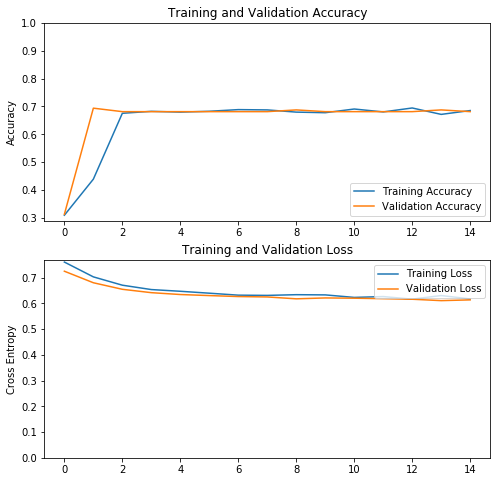

In [23]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

## Fine-Tuning

In Transfer Learning the original pre-trained model is locked or frozen during training of the new classifier. This ensures that the weights of the original model will not change. One advantage of this, is that the training of the new classifier will not propagate large gradients back through the model that may either distort its weights or cause overfitting to the new dataset.

However, once the new classifier has been trained we can try and gently fine-tune some of the deeper layers in the model as well, in order to improve classification performance.

In [24]:
# Fine Tuning - we need to unfreeze the desired layers of the base_model, and set the bottom layers to be un-trainable. 
# Then, recompile the model (necessary for these changes to take effect), and resume training.
base_model.trainable = True

In [ ]:
## we chose to train the top 2 inception blocks, i.e. we will freeze
## the first 249 layers and unfreeze the rest:
#for layer in base_model.layers[:249]:
#   layer.trainable = False
#for layer in base_model.layers[249:]:
#   layer.trainable = True

In [25]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  19


In [26]:
# Fine tune from this layer onwards (100 for mobilnet)
fine_tune_at = 11

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [27]:
def print_layer_trainable(model):
    for layer in model.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))

In [28]:
print_layer_trainable(base_model)

False:	input_1
False:	block1_conv1
False:	block1_conv2
False:	block1_pool
False:	block2_conv1
False:	block2_conv2
False:	block2_pool
False:	block3_conv1
False:	block3_conv2
False:	block3_conv3
False:	block3_pool
True:	block4_conv1
True:	block4_conv2
True:	block4_conv3
True:	block4_pool
True:	block5_conv1
True:	block5_conv2
True:	block5_conv3
True:	block5_pool


In [29]:
model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 513       
Total params: 14,715,201
Trainable params: 12,979,713
Non-trainable params: 1,735,488
_________________________________________________________________


In [31]:
len(model.trainable_variables)

14

In [32]:
model_save_path = '/data/mwir_gun_chips/saved_models/'
model_name = 'mwir_guns_VGG_model'                       # VGG
#model_name = 'guns_inception_model'              # inceptionV3

In [33]:
# Save the model according to the conditions  
checkpoint = ModelCheckpoint(model_save_path+model_name+"_epoch{epoch:02d}-loss{loss:.2f}.h5", monitor='val_acc', verbose=1, save_best_only=True,  mode='max' )

In [34]:
callbacks_list = [checkpoint]

In [35]:
history_fine = model.fit_generator(train_generator,
                                   steps_per_epoch = steps_per_epoch,
                                   epochs=epochs,
                                   #callbacks=callbacks_list,
                                   workers=4,
                                   validation_data=validation_generator,
                                   validation_steps=validation_steps)

Epoch 1/15
44/45 [============================>.] - ETA: 0s - loss: 0.3426 - acc: 0.8487
Epoch 00001: val_acc improved from -inf to 0.93750, saving model to /data/mwir_gun_chips/saved_models/mwir_guns_VGG_model_epoch01-loss0.34.h5
45/45 [==============================] - 10s 219ms/step - loss: 0.3399 - acc: 0.8500 - val_loss: 0.1709 - val_acc: 0.9375
Epoch 2/15
44/45 [============================>.] - ETA: 0s - loss: 0.1532 - acc: 0.9467
Epoch 00002: val_acc did not improve from 0.93750
45/45 [==============================] - 7s 148ms/step - loss: 0.1512 - acc: 0.9479 - val_loss: 0.1279 - val_acc: 0.9187
Epoch 3/15
44/45 [============================>.] - ETA: 0s - loss: 0.1363 - acc: 0.9589
Epoch 00003: val_acc did not improve from 0.93750
45/45 [==============================] - 7s 148ms/step - loss: 0.1348 - acc: 0.9592 - val_loss: 0.1045 - val_acc: 0.9375
Epoch 4/15
44/45 [============================>.] - ETA: 0s - loss: 0.0531 - acc: 0.9805
Epoch 00004: val_acc improved from 0.9

After training we can also evaluate the new model's performance on the test-set using a single function call in the Keras API.

In [36]:
result = model.evaluate_generator(validation_generator, steps=steps_per_epoch)
print("Test-set classification accuracy: {0:.2%}".format(result[1]))

Test-set classification accuracy: 99.35%


In [37]:
acc += history_fine.history['acc']
val_acc += history_fine.history['val_acc']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

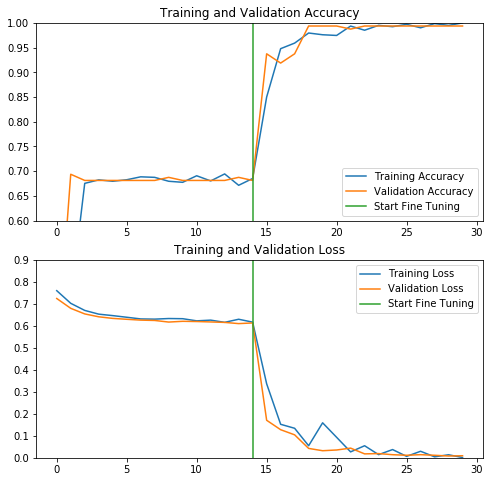

In [38]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.6, 1])
plt.plot([epochs-1,epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 0.9])
plt.plot([epochs-1,epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


## Exploring the data
We cam explore the data to learn how we might improve training.

In [39]:
import pathlib

data_root = pathlib.Path(test_dir)
print(data_root)

/data/mwir_gun_chips/val


In [40]:
## how many images are in this section (train or test) of dataset
import random
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
image_count

161

In [41]:
all_image_paths[:8]

['/data/mwir_gun_chips/val/nogun/236_3533.png',
 '/data/mwir_gun_chips/val/nogun/236_3138.png',
 '/data/mwir_gun_chips/val/nogun/236_4109.png',
 '/data/mwir_gun_chips/val/nogun/236_4383.png',
 '/data/mwir_gun_chips/val/gun/252_0959.png',
 '/data/mwir_gun_chips/val/gun/236_5227.png',
 '/data/mwir_gun_chips/val/nogun/236_3064.png',
 '/data/mwir_gun_chips/val/nogun/236_5398.png']

In [1]:
# for n in range(10):
#     image_path = random.choice(all_image_paths)
#     img = image.load_img(image_path, target_size=(image_size, image_size))
#     img_tensor = image.img_to_array(img)
#     img_tensor = np.expand_dims(img_tensor, axis=0)
#     img_tensor /= 255.
#     pred = model.predict_proba(img_tensor)
#     plt.imshow(img_tensor[0])
#     plt.show()
#     print(image_path)
#     print('Probabililty of gun(0)/nogun(1) = ', pred)

### Visualizing Layer Activations (TBD)
Let's look at the output from each layer to get an idea of what is being learning.

In [ ]:
#image_path = '/data/gun_chips/train/gun/246_0012.png'
#img = image.load_img(image_path, target_size=(256, 256))
#img_tensor = image.img_to_array(img)
#img_tensor = np.expand_dims(img_tensor, axis=0)
#img_tensor /= 255.

#classes = model.predict_classes(img_tensor)
#print("Predicted class is:",classes)

In [ ]:
# from tensorflow.python.keras import models
# layer_outputs = [layer.output for layer in base_model.layers[:2]] 
# # Extracts the outputs of the top 12 layers
# # Creates a model that will return these outputs, given the model input
# activation_model = models.Model(inputs=base_model.input, outputs=layer_outputs)



In [ ]:
# # Run the model in predict mode
# activations = activation_model.predict(img_tensor) 
# # Returns a list of five Numpy arrays: one array per layer activation

In [ ]:
# first_layer_activation = activations[0]
# print(first_layer_activation.shape)


In [ ]:
# plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')

In [ ]:
# layer_names = []
# for layer in classifier.layers[:12]:
#     layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
# images_per_row = 16

# for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
#     n_features = layer_activation.shape[-1] # Number of features in the feature map
#     size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
#     n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
#     display_grid = np.zeros((size * n_cols, images_per_row * size))
#     for col in range(n_cols): # Tiles each filter into a big horizontal grid
#         for row in range(images_per_row):
#             channel_image = layer_activation[0,
#                                              :, :,
#                                              col * images_per_row + row]
#             channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
#             channel_image /= channel_image.std()
#             channel_image *= 64
#             channel_image += 128
#             channel_image = np.clip(channel_image, 0, 255).astype('uint8')
#             display_grid[col * size : (col + 1) * size, # Displays the grid
#                          row * size : (row + 1) * size] = channel_image
#     scale = 1. / size
#     plt.figure(figsize=(scale * display_grid.shape[1],
#                         scale * display_grid.shape[0]))
#     plt.title(layer_name)
#     plt.grid(False)
#     plt.imshow(display_grid, aspect='auto', cmap='viridis')

## Example Predictions

Here we will show a few examples of using our trained model for predictions.

In [ ]:
cls_train = train_generator.classes
cls_test = validation_generator.classes

In [ ]:
class_names = list(train_generator.class_indices.keys())
class_names

In [ ]:
num_classes = train_generator.num_classes
num_classes

In [ ]:
def predict(image_path):
    # Load and resize the image using PIL.
    img = PIL.Image.open(image_path)
    img_resized = img.resize(input_shape, PIL.Image.LANCZOS)

    # Plot the image.
    plt.imshow(img_resized)
    plt.show()

    # Convert the PIL image to a numpy-array with the proper shape.
    img_array = np.expand_dims(np.array(img_resized), axis=0)
    rescale=1./255
    img_scaled = img_array*rescale
  

    # Use the model to make a prediction.
    #pred = model.predict_classes(img_array)
    pred = model.predict_proba(img_scaled)
   # pred = model.predict(img_array)
    
    # Decode the output of the VGG16 model.
    #pred_decoded = decode_predictions(pred)[0]

    # Print the predictions.
    #for code, name, score in pred_decoded:
    #    print("{0:>6.2%} : {1}".format(score, name))
    
    print('Probabililty of gun(0)/nogun(1) = ', pred)
    
    

In [ ]:
 predict(image_path = '/data/gun_chips/val/nogun/250_0735.png')

We can run prediction on any image in our dataset by selecting a path from list.

In [ ]:
predict(image_path='/data/gun_chips/val/gun/323.jpeg')

## Conclusion

We showed how to use the Keras API to do both Transfer Learning and Fine-Tuning of the pre-trained model on a new dataset. It is much easier to implement this using the Keras API rather than directly in TensorFlow.

Whether or not, Fine-Tuning improves the classification accuracy over just using Transfer Learning depends on the pre-trained model, the transfer-layer you choose, your dataset, and how you train the new model. You may experience improved performance from the fine-tuning, or you may experience worse performance if the fine-tuned model is overfitting your training-data.